In [1]:
# Needed to reload modified modules
%load_ext autoreload
%autoreload 2

In [3]:
# Evaluate the Encoder-Decoder models

import os
import numpy as np
import matplotlib.pyplot as plt
from utils import fast_tensor_load_encdec
from models import TomoscopeOld as Tomoscope
# from local_utils import get_best_model_timestamp

data_dir = './tomo_data/datasets_tomoscope_TF_24-03-23'

train_cfg = {
    'normalization': 'minmax',
    'ps_normalize': 'off',
    'img_normalize': 'off',
    'output_turns': 10,
    'dataset%': 1,
}

var_names = ['phEr', 'enEr', 'bl', 'inten', 'Vrf', 'mu', 'VrfSPS']

# enc_timestamp = get_best_model_timestamp('./trials', model='enc')
timestamp = 'best_tomoscope'
# timestamp = '2023_07_21_17-23-19'



In [4]:
# Initialize parameters
import time

# Initialize train/ test / validation paths
ML_dir = os.path.join(data_dir, 'ML_data')
assert os.path.exists(ML_dir)

TESTING_PATH = os.path.join(ML_dir, 'tomoscope-testing-??.npz')

np.random.seed(0)

assert train_cfg['normalization'] == 'minmax'
assert train_cfg['img_normalize'] == 'off'
assert train_cfg['ps_normalize'] == 'off'

# First the training data

start_t = time.time()
wf_test, turn_test, latent_test, ps_test = fast_tensor_load_encdec(
    TESTING_PATH, train_cfg['dataset%'])

ps_test = ps_test[:, :, :, :train_cfg['output_turns']]

print('Number of Testing files: ', len(turn_test))
total_time = time.time() - start_t
print(f'Elapsed time: {total_time:.3f}, Per file: {total_time/len(turn_test):.3f}')


Loading ./tomo_data/datasets_tomoscope_TF_24-03-23/ML_data/tomoscope-testing-00.npz


2024-01-23 17:08:24.955758: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kiliakis/install/anaconda3/lib:/home/kiliakis/install/lib
2024-01-23 17:08:25.005203: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-01-23 17:08:25.017348: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sy153): /proc/driver/nvidia/version does not exist
2024-01-23 17:08:25.212593: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appr

Number of Testing files:  1396
Elapsed time: 10.583, Per file: 0.008


In [5]:
print('WF shape:', wf_test.shape)
print('Turn shape:', turn_test.shape)
print('Latent shape:', latent_test.shape)
print('PS shape:', ps_test.shape)

WF shape: (1396, 128, 128, 1)
Turn shape: (1396, 10)
Latent shape: (1396, 7)
PS shape: (1396, 128, 128, 10)


In [6]:
# Models to load
print('Tomoscope: ', timestamp)

# Initialize directories
trial_dir = os.path.join('./trials/', timestamp)
plots_dir = os.path.join('./trials/', timestamp, 'plots')
weights_dir = os.path.join(trial_dir, 'weights')

assert os.path.exists(weights_dir)
os.makedirs(plots_dir, exist_ok=True)

tomoscope = Tomoscope()
tomoscope.load(weights_dir=weights_dir)


Tomoscope:  best_tomoscope


In [7]:
tomoscope.model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 128, 128, 1)]     0         
                                                                 
 crop (Cropping2D)           (None, 128, 128, 1)       0         
                                                                 
 encoder_cnn_1 (Conv2D)      (None, 60, 60, 16)        1296      
                                                                 
 tf.nn.relu (TFOpLambda)     (None, 60, 60, 16)        0         
                                                                 
 encoder_cnn_2 (Conv2D)      (None, 27, 27, 32)        25088     
                                                                 
 tf.nn.relu_1 (TFOpLambda)   (None, 27, 27, 32)        0         
                                                                 
 encoder_cnn_3 (Conv2D)      (None, 12, 12, 64)        51200 

In [16]:
# import visualkeras

# visualkeras.layered_view(tomoscope.model, to_file=os.path.join(plots_dir, 'tomoscope-model.png'), 
#                          legend=True, index_ignore=[1], max_z=100, max_xy=400, draw_volume=True).show()

In [8]:

# Evaluate the model on the test and validation data
ps_pred = tomoscope.predict(wf_test)

# Evaluate the PS agreement
ps_mse = np.mean(np.absolute(ps_test[:, 14:-14, 14:-14] - ps_pred[:, 14:-14, 14:-14]), axis=0)
# ps_mse = np.mean((ps_test[:, 14:-14, 14:-14] - ps_pred[:, 14:-14, 14:-14])**2,
#                           axis=0).reshape((100, 100))
print('\nPS Tomoscope MAE: ', np.mean(ps_mse))


PS Tomoscope MAE:  0.0009908732


PS True, min: 0.0, max: 0.18413999676704407
PS Pred, min: 0.0, max: 0.17320063710212708


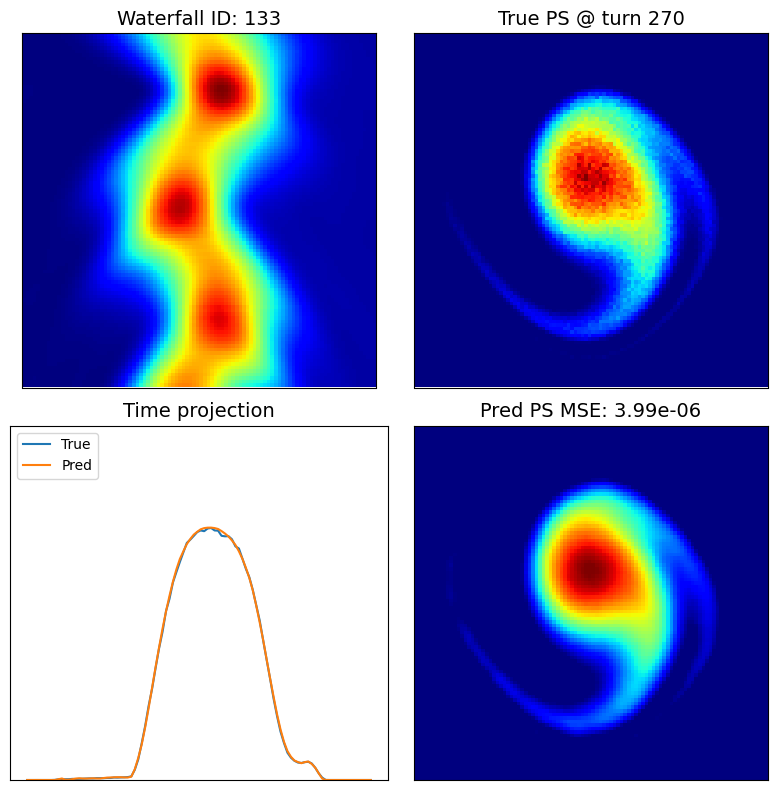

In [19]:
# Here we need animation with WF on the left, real PS in the middle, predicted on the right
'''
Visual end-to-end evaluation. 
Left: Waterfall (input)
Middle: Bar plot with features (latent space), real and predicted. For the evaluation of the encoder. 
Middle bottom: PS at a given turn, real and predicted. For the evaluation of the decoder. 
'''
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

fig, axes = plt.subplot_mosaic(mosaic=[['WF', 'PS_TRUE'], 
                                       ['Time projection', 'PS_PRED']],
                               gridspec_kw={'width_ratios': [3, 3]},
                               sharex=False, sharey=False,
                               #        'hspace': 0.1, 'wspace': 0.2},
                               figsize=(8, 8)
                        )

# get random id
# sample_id = np.random.randint(low=0, high=len(wf_test))
sample_id = 133

wf_s = np.array(wf_test[sample_id, 14:-14, 14:-14]).reshape(100, 100).T

# turn_id = 9
ps_true_s = ps_test[sample_id, 14:-14, 14:-14]
ps_pred_s = ps_pred[sample_id, 14:-14, 14:-14]

time_proj_true = np.sum(ps_true_s[:, :, 0], axis=0)
time_proj_pred = np.sum(ps_pred_s[:, :, 0], axis=0)

energy_proj_true = np.sum(ps_true_s[:, :, 0], axis=1)
energy_proj_pred = np.sum(ps_pred_s[:, :, 0], axis=1)

diff = np.abs(ps_pred_s[:, :, 0] - ps_true_s[:, :, 0])

# # start with left plot, the waterfall
plt.sca(axes['WF'])
plt.imshow(wf_s, cmap='jet')
plt.title(f'Waterfall ID: {sample_id}', fontsize=14)
plt.xticks([], []); plt.yticks([], [])


# middle plot
plt.sca(axes['PS_TRUE'])
print(f'PS True, min: {np.min(ps_true_s)}, max: {np.max(ps_true_s)}')
middle_img = plt.imshow(ps_true_s[:, :, 0], cmap='jet')
plt.title(f'True PS @ turn 0', fontsize=14)
plt.xticks([], []); plt.yticks([], [])

# right plot
plt.sca(axes['PS_PRED'])
print(f'PS Pred, min: {np.min(ps_pred_s)}, max: {np.max(ps_pred_s)}')
right_img = plt.imshow(ps_pred_s[:, :, 0], cmap='jet')
plt.title(f'Pred PS MSE:{np.mean((ps_pred_s[:, :, 0] - ps_true_s[:, :, 0])**2):.2e}', fontsize=14)
plt.xticks([], []); plt.yticks([], [])

# right plot
# plt.sca(axes['Difference'])
# # print(f'PS Pred, min: {np.min(ps_pred_s)}, max: {np.max(ps_pred_s)}')
# diff_img = plt.imshow(np.abs(ps_pred_s[:, :, 0] - ps_true_s[:, :, 0]), cmap='jet', vmin=0, vmax=0.2)
# plt.title(f'Difference', fontsize=14)
# plt.xticks([], []); plt.yticks([], [])

# middle plot
plt.sca(axes['Time projection'])
# print(f'PS True, min: {np.min(ps_true_s)}, max: {np.max(ps_true_s)}')
x_array = np.arange(ps_true_s.shape[0])
time_plot_true, = plt.plot(x_array, np.sum(ps_true_s[:, :, 0], axis=0), label='True')
time_plot_pred, = plt.plot(x_array, np.sum(ps_pred_s[:, :, 0], axis=0), label='Pred')
plt.legend(loc='upper left')
plt.title(f'Time projection', fontsize=14)
plt.xticks([], []); plt.yticks([], [])
plt.ylim(0, 1.1*np.max(np.sum(ps_true_s[:, :, :], axis=0)))


# plt.sca(axes['Energy projection'])
# # print(f'PS True, min: {np.min(ps_true_s)}, max: {np.max(ps_true_s)}')
# energy_plot_true, = plt.plot(x_array, np.sum(ps_true_s[:, :, 0], axis=1), label='True')
# energy_plot_pred, = plt.plot(x_array, np.sum(ps_pred_s[:, :, 0], axis=1), label='Pred')
# plt.legend(loc='upper left')
# plt.title(f'Energy projection', fontsize=14)
# plt.xticks([], []); plt.yticks([], [])
# plt.ylim(0, 1.1*np.max(np.sum(ps_true_s[:, :, :], axis=1)))


plt.tight_layout()

def animate(i):
    # update the data
    middle_img.set_data(ps_true_s[:, :, i])
    axes['PS_TRUE'].set_title(f'True PS @ turn {i*30}', fontsize=14)
    right_img.set_data(ps_pred_s[:, :, i])
    axes['PS_PRED'].set_title(f'Pred PS MSE: {np.mean((ps_pred_s[:, :, i] - ps_true_s[:, :, i])**2):.2e}', fontsize=14)

    # diff_img.set_data(np.abs(ps_pred_s[:, :, i] - ps_true_s[:, :, i]))
    # axes['Difference'].set_title(f'Difference', fontsize=14)

    # axes['Time projection'].plot(np.sum(ps_true_s[:, :, i], axis=0), label='True')
    # axes['Time projection'].plot(np.sum(ps_pred_s[:, :, i], axis=0), label='Predicted')

    # axes['Energy projection'].plot(np.sum(ps_true_s[:, :, i], axis=1), label='True')
    # axes['Energy projection'].plot(np.sum(ps_pred_s[:, :, i], axis=1), label='Predicted')

    time_plot_true.set_data(x_array, np.sum(ps_true_s[:, :, i], axis=0))
    time_plot_pred.set_data(x_array, np.sum(ps_pred_s[:, :, i], axis=0))

    # energy_plot_true.set_data(x_array, np.sum(ps_true_s[:, :, i], axis=1))
    # energy_plot_pred.set_data(x_array, np.sum(ps_pred_s[:, :, i], axis=1))

    return [middle_img, right_img, time_plot_true, time_plot_pred]

    # return [middle_img, right_img, diff_img, time_plot_true, time_plot_pred, energy_plot_true, energy_plot_pred]

# plt.tight_layout()
anim = animation.FuncAnimation(fig, animate, frames=ps_pred_s.shape[-1], 
                               interval=500, blit=True)
HTML(anim.to_html5_video())
anim.save(os.path.join(plots_dir, f'tomoscope{timestamp}_wf{sample_id}_with_time_projection.gif'), dpi=200)
# plt.savefig(os.path.join(plots_dir, f'encDec_id{sample_id}_turn{turn_s}.jpg'), dpi=400)


PS True, min: 0.0, max: 0.0910043939948082
PS Pred, min: 0.0, max: 0.08686035126447678


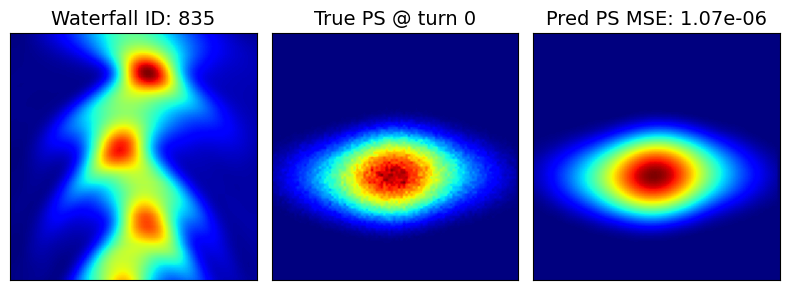

In [12]:
# Here we need animation with WF on the left, real PS in the middle, predicted on the right
'''
Visual end-to-end evaluation. 
Left: Waterfall (input)
Middle: Bar plot with features (latent space), real and predicted. For the evaluation of the encoder. 
Middle bottom: PS at a given turn, real and predicted. For the evaluation of the decoder. 
'''
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

fig, axes = plt.subplot_mosaic(mosaic=[['WF', 'PS_TRUE', 'PS_PRED']],
                               gridspec_kw={'width_ratios': [3, 3, 3]},
                               #        'hspace': 0.1, 'wspace': 0.2},
                               figsize=(8, 3.6)
                        )

# get random id
# sample_id = np.random.randint(low=0, high=len(wf_test))
sample_id = 133

wf_s = np.array(wf_test[sample_id, 14:-14, 14:-14]).reshape(100, 100).T

# turn_id = 9
ps_true_s = ps_test[sample_id, 14:-14, 14:-14]
ps_pred_s = ps_pred[sample_id, 14:-14, 14:-14]

# # start with left plot, the waterfall
plt.sca(axes['WF'])
plt.imshow(wf_s, cmap='jet')
plt.title(f'Waterfall ID: {sample_id}', fontsize=14)
plt.xticks([], []); plt.yticks([], [])


# middle plot
plt.sca(axes['PS_TRUE'])
print(f'PS True, min: {np.min(ps_true_s)}, max: {np.max(ps_true_s)}')
middle_img = plt.imshow(ps_true_s[:, :, 0], cmap='jet')
plt.title(f'True PS @ turn 0', fontsize=14)
plt.xticks([], []); plt.yticks([], [])

# right plot
plt.sca(axes['PS_PRED'])
print(f'PS Pred, min: {np.min(ps_pred_s)}, max: {np.max(ps_pred_s)}')
right_img = plt.imshow(ps_pred_s[:, :, 0], cmap='jet')
plt.title(f'Pred PS MSE:{np.mean((ps_pred_s[:, :, 0] - ps_true_s[:, :, 0])**2):.2e}', fontsize=14)
plt.xticks([], []); plt.yticks([], [])
plt.tight_layout()
def animate(i):
    # update the data
    middle_img.set_data(ps_true_s[:, :, i])
    axes['PS_TRUE'].set_title(f'True PS @ turn {i*30}', fontsize=14)
    right_img.set_data(ps_pred_s[:, :, i])
    axes['PS_PRED'].set_title(f'Pred PS MSE: {np.mean((ps_pred_s[:, :, i] - ps_true_s[:, :, i])**2):.2e}', fontsize=14)
    return [middle_img, right_img]

# plt.tight_layout()
anim = animation.FuncAnimation(fig, animate, frames=ps_pred_s.shape[-1], 
                               interval=400, blit=True)
HTML(anim.to_html5_video())
anim.save(os.path.join(plots_dir, f'tomoscope{timestamp}_wf{sample_id}.gif'), dpi=400)
# plt.savefig(os.path.join(plots_dir, f'encDec_id{sample_id}_turn{turn_s}.jpg'), dpi=400)


PS True, min: 0.0, max: 0.14629971981048584
PS Pred, min: 0.0, max: 0.1373211294412613


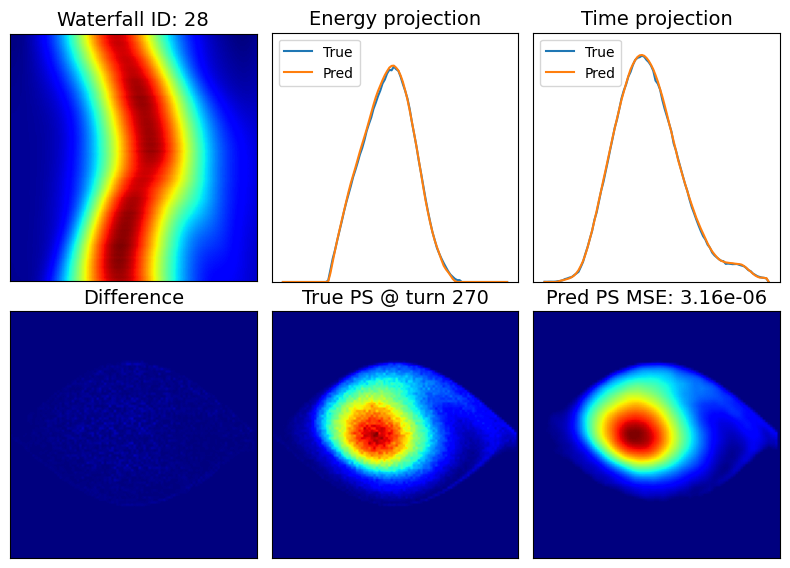

In [36]:
# Here we need animation with WF on the left, real PS in the middle, predicted on the right
'''
Visual end-to-end evaluation. 
Left: Waterfall (input)
Middle: Bar plot with features (latent space), real and predicted. For the evaluation of the encoder. 
Middle bottom: PS at a given turn, real and predicted. For the evaluation of the decoder. 
'''
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

fig, axes = plt.subplot_mosaic(mosaic=[['WF', 'Energy projection', 'Time projection'], 
                                       ['Difference', 'PS_TRUE', 'PS_PRED']],
                               gridspec_kw={'width_ratios': [3, 3, 3]},
                               sharex=False, sharey=False,
                               #        'hspace': 0.1, 'wspace': 0.2},
                               figsize=(8, 5.8)
                        )

# get random id
# sample_id = np.random.randint(low=0, high=len(wf_test))
sample_id = 28

wf_s = np.array(wf_test[sample_id, 14:-14, 14:-14]).reshape(100, 100).T

# turn_id = 9
ps_true_s = ps_test[sample_id, 14:-14, 14:-14]
ps_pred_s = ps_pred[sample_id, 14:-14, 14:-14]

time_proj_true = np.sum(ps_true_s[:, :, 0], axis=0)
time_proj_pred = np.sum(ps_pred_s[:, :, 0], axis=0)

energy_proj_true = np.sum(ps_true_s[:, :, 0], axis=1)
energy_proj_pred = np.sum(ps_pred_s[:, :, 0], axis=1)

diff = np.abs(ps_pred_s[:, :, 0] - ps_true_s[:, :, 0])

# # start with left plot, the waterfall
plt.sca(axes['WF'])
plt.imshow(wf_s, cmap='jet')
plt.title(f'Waterfall ID: {sample_id}', fontsize=14)
plt.xticks([], []); plt.yticks([], [])


# middle plot
plt.sca(axes['PS_TRUE'])
print(f'PS True, min: {np.min(ps_true_s)}, max: {np.max(ps_true_s)}')
middle_img = plt.imshow(ps_true_s[:, :, 0], cmap='jet')
plt.title(f'True PS @ turn 0', fontsize=14)
plt.xticks([], []); plt.yticks([], [])

# right plot
plt.sca(axes['PS_PRED'])
print(f'PS Pred, min: {np.min(ps_pred_s)}, max: {np.max(ps_pred_s)}')
right_img = plt.imshow(ps_pred_s[:, :, 0], cmap='jet')
plt.title(f'Pred PS MSE:{np.mean((ps_pred_s[:, :, 0] - ps_true_s[:, :, 0])**2):.2e}', fontsize=14)
plt.xticks([], []); plt.yticks([], [])

# right plot
plt.sca(axes['Difference'])
# print(f'PS Pred, min: {np.min(ps_pred_s)}, max: {np.max(ps_pred_s)}')
diff_img = plt.imshow(np.abs(ps_pred_s[:, :, 0] - ps_true_s[:, :, 0]), cmap='jet', vmin=0, vmax=0.2)
plt.title(f'Difference', fontsize=14)
plt.xticks([], []); plt.yticks([], [])

# middle plot
plt.sca(axes['Time projection'])
# print(f'PS True, min: {np.min(ps_true_s)}, max: {np.max(ps_true_s)}')
x_array = np.arange(ps_true_s.shape[0])
time_plot_true, = plt.plot(x_array, np.sum(ps_true_s[:, :, 0], axis=0), label='True')
time_plot_pred, = plt.plot(x_array, np.sum(ps_pred_s[:, :, 0], axis=0), label='Pred')
plt.legend(loc='upper left')
plt.title(f'Time projection', fontsize=14)
plt.xticks([], []); plt.yticks([], [])
plt.ylim(0, 1.1*np.max(np.sum(ps_true_s[:, :, :], axis=0)))


plt.sca(axes['Energy projection'])
# print(f'PS True, min: {np.min(ps_true_s)}, max: {np.max(ps_true_s)}')
energy_plot_true, = plt.plot(x_array, np.sum(ps_true_s[:, :, 0], axis=1), label='True')
energy_plot_pred, = plt.plot(x_array, np.sum(ps_pred_s[:, :, 0], axis=1), label='Pred')
plt.legend(loc='upper left')
plt.title(f'Energy projection', fontsize=14)
plt.xticks([], []); plt.yticks([], [])
plt.ylim(0, 1.1*np.max(np.sum(ps_true_s[:, :, :], axis=1)))


plt.tight_layout()

def animate(i):
    # update the data
    middle_img.set_data(ps_true_s[:, :, i])
    axes['PS_TRUE'].set_title(f'True PS @ turn {i*30}', fontsize=14)
    right_img.set_data(ps_pred_s[:, :, i])
    axes['PS_PRED'].set_title(f'Pred PS MSE: {np.mean((ps_pred_s[:, :, i] - ps_true_s[:, :, i])**2):.2e}', fontsize=14)

    diff_img.set_data(np.abs(ps_pred_s[:, :, i] - ps_true_s[:, :, i]))
    axes['Difference'].set_title(f'Difference', fontsize=14)

    # axes['Time projection'].plot(np.sum(ps_true_s[:, :, i], axis=0), label='True')
    # axes['Time projection'].plot(np.sum(ps_pred_s[:, :, i], axis=0), label='Predicted')

    # axes['Energy projection'].plot(np.sum(ps_true_s[:, :, i], axis=1), label='True')
    # axes['Energy projection'].plot(np.sum(ps_pred_s[:, :, i], axis=1), label='Predicted')

    time_plot_true.set_data(x_array, np.sum(ps_true_s[:, :, i], axis=0))
    time_plot_pred.set_data(x_array, np.sum(ps_pred_s[:, :, i], axis=0))

    energy_plot_true.set_data(x_array, np.sum(ps_true_s[:, :, i], axis=1))
    energy_plot_pred.set_data(x_array, np.sum(ps_pred_s[:, :, i], axis=1))


    return [middle_img, right_img, diff_img, time_plot_true, time_plot_pred, energy_plot_true, energy_plot_pred]

# plt.tight_layout()
anim = animation.FuncAnimation(fig, animate, frames=ps_pred_s.shape[-1], 
                               interval=500, blit=True)
HTML(anim.to_html5_video())
anim.save(os.path.join(plots_dir, f'tomoscope{timestamp}_wf{sample_id}_with_projections.gif'), dpi=400)
# plt.savefig(os.path.join(plots_dir, f'encDec_id{sample_id}_turn{turn_s}.jpg'), dpi=400)

In [16]:
from utils import assess_decoder
num_samples = 20
assess_decoder(ps_pred[:num_samples], turn_test[:num_samples], ps_test[:num_samples],
               plots_dir=plots_dir, savefig=True)


In [13]:
from utils import assess_model
num_samples = 20
assess_model(ps_pred[:num_samples], turn_test[:num_samples], wf_test[:num_samples], ps_test[:num_samples],
             plots_dir=plots_dir, savefig=True, with_projections=True)
